In [187]:
%reload_ext autoreload
%autoreload 2
import main
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 30]

In [6]:
import fastai as fai
from main import *

In [117]:
maxsize=100000
batch_size=4096
indices = np.random.RandomState(seed=42).permutation(maxsize)

val_indices, train_indices = indices[:maxsize//10], indices[maxsize//10:]

In [118]:
train_dl = fai.basic_data.DataLoader(DatasetFromHdf5('data/train_dataset.h5', maxsize=len(train_indices)), 
                        batch_size=batch_size,
                        sampler=SubsetRandomSampler(train_indices),
                         num_workers=2)

In [119]:
val_dl = fai.basic_data.DataLoader(DatasetFromHdf5('data/train_dataset.h5', maxsize=len(val_indices)), 
                        batch_size=batch_size, 
                        sampler=SubsetRandomSampler(val_indices),
                         num_workers=2)

In [120]:
db = fai.basic_data.DataBunch(train_dl, val_dl)

In [98]:
input_size = train_dl.dataset.programs.shape[1] + 2*train_dl.dataset.schedules.shape[1] 
output_size = 1

In [121]:
m = Model(input_size, output_size)
criterion = nn.MSELoss()

In [100]:
l = fai.Learner(db, m, loss_func=criterion)

In [101]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


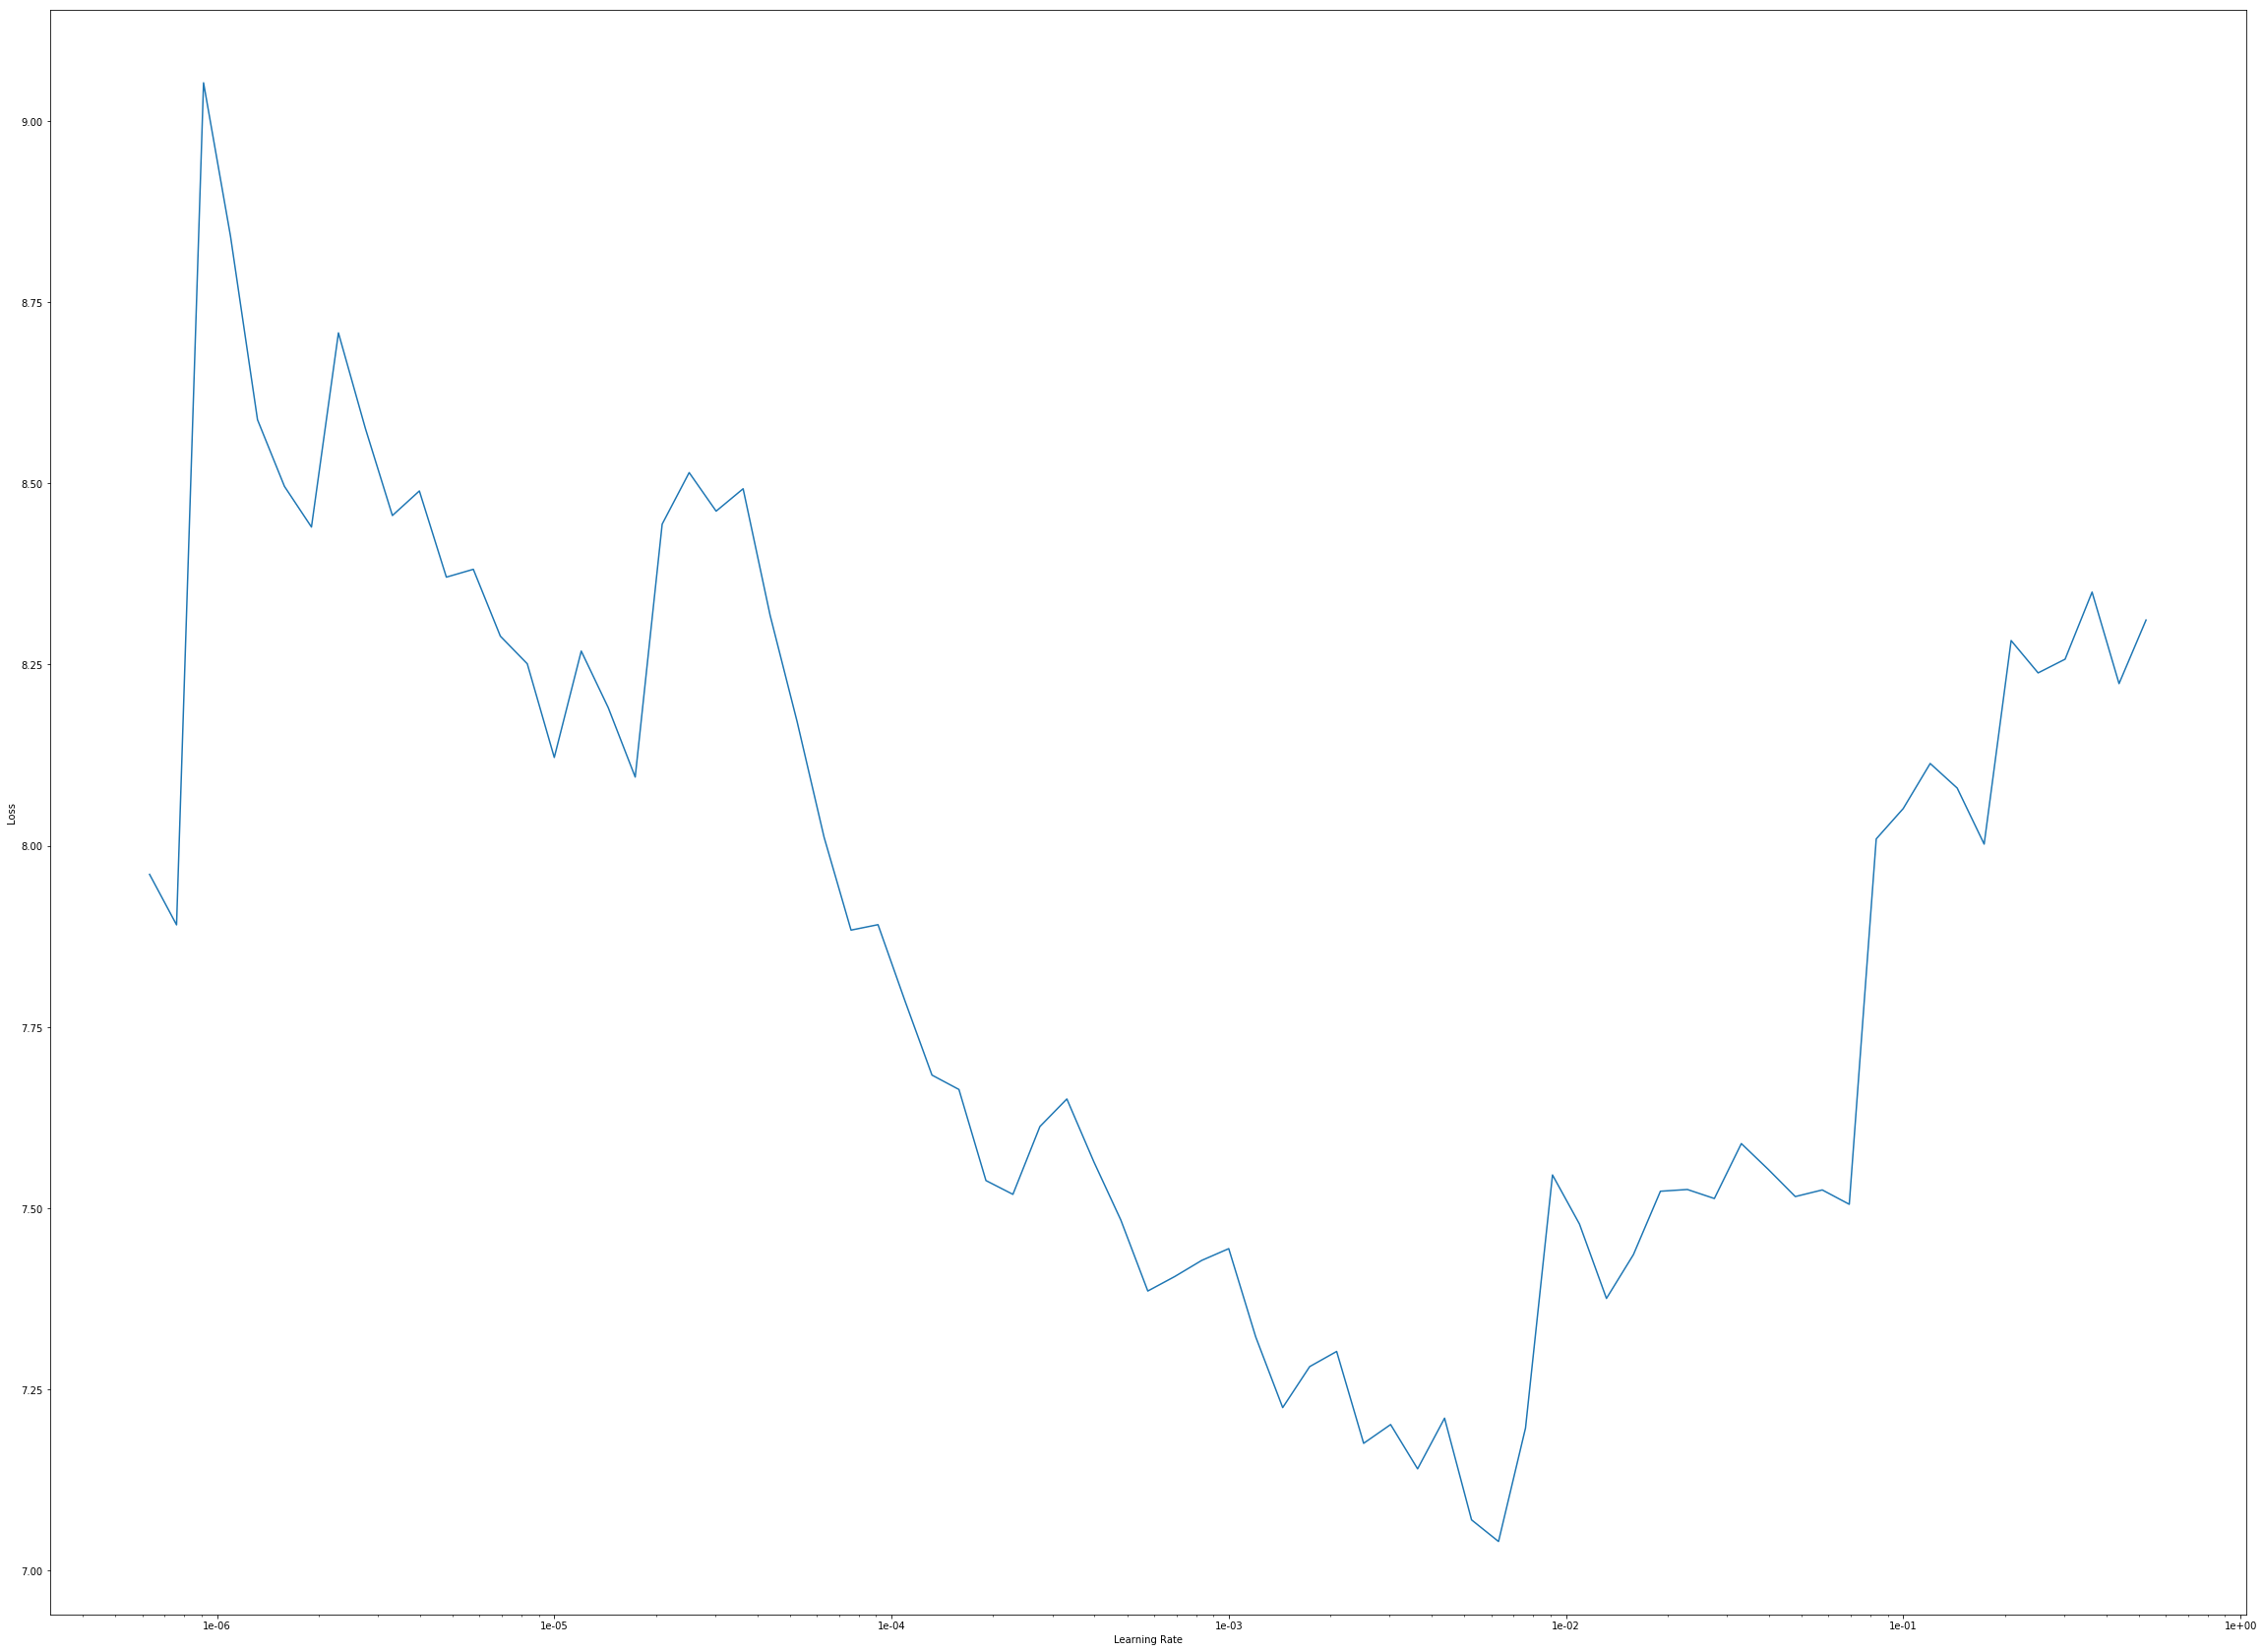

In [102]:
l.recorder.plot()

In [125]:
lr = 0.01

In [23]:
%load_ext line_profiler
%lprun 

In [104]:
l.fit(1000, lr)

epoch,train_loss,valid_loss
1,5.899198,6.070301
2,6.175047,6.282885
3,5.741931,6.127903
4,5.883423,5.660659
5,4.953372,5.313233
6,5.371163,5.058182
7,5.284485,6.438532
8,5.388159,5.073066
9,5.288509,5.151852
10,5.146525,5.982287


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



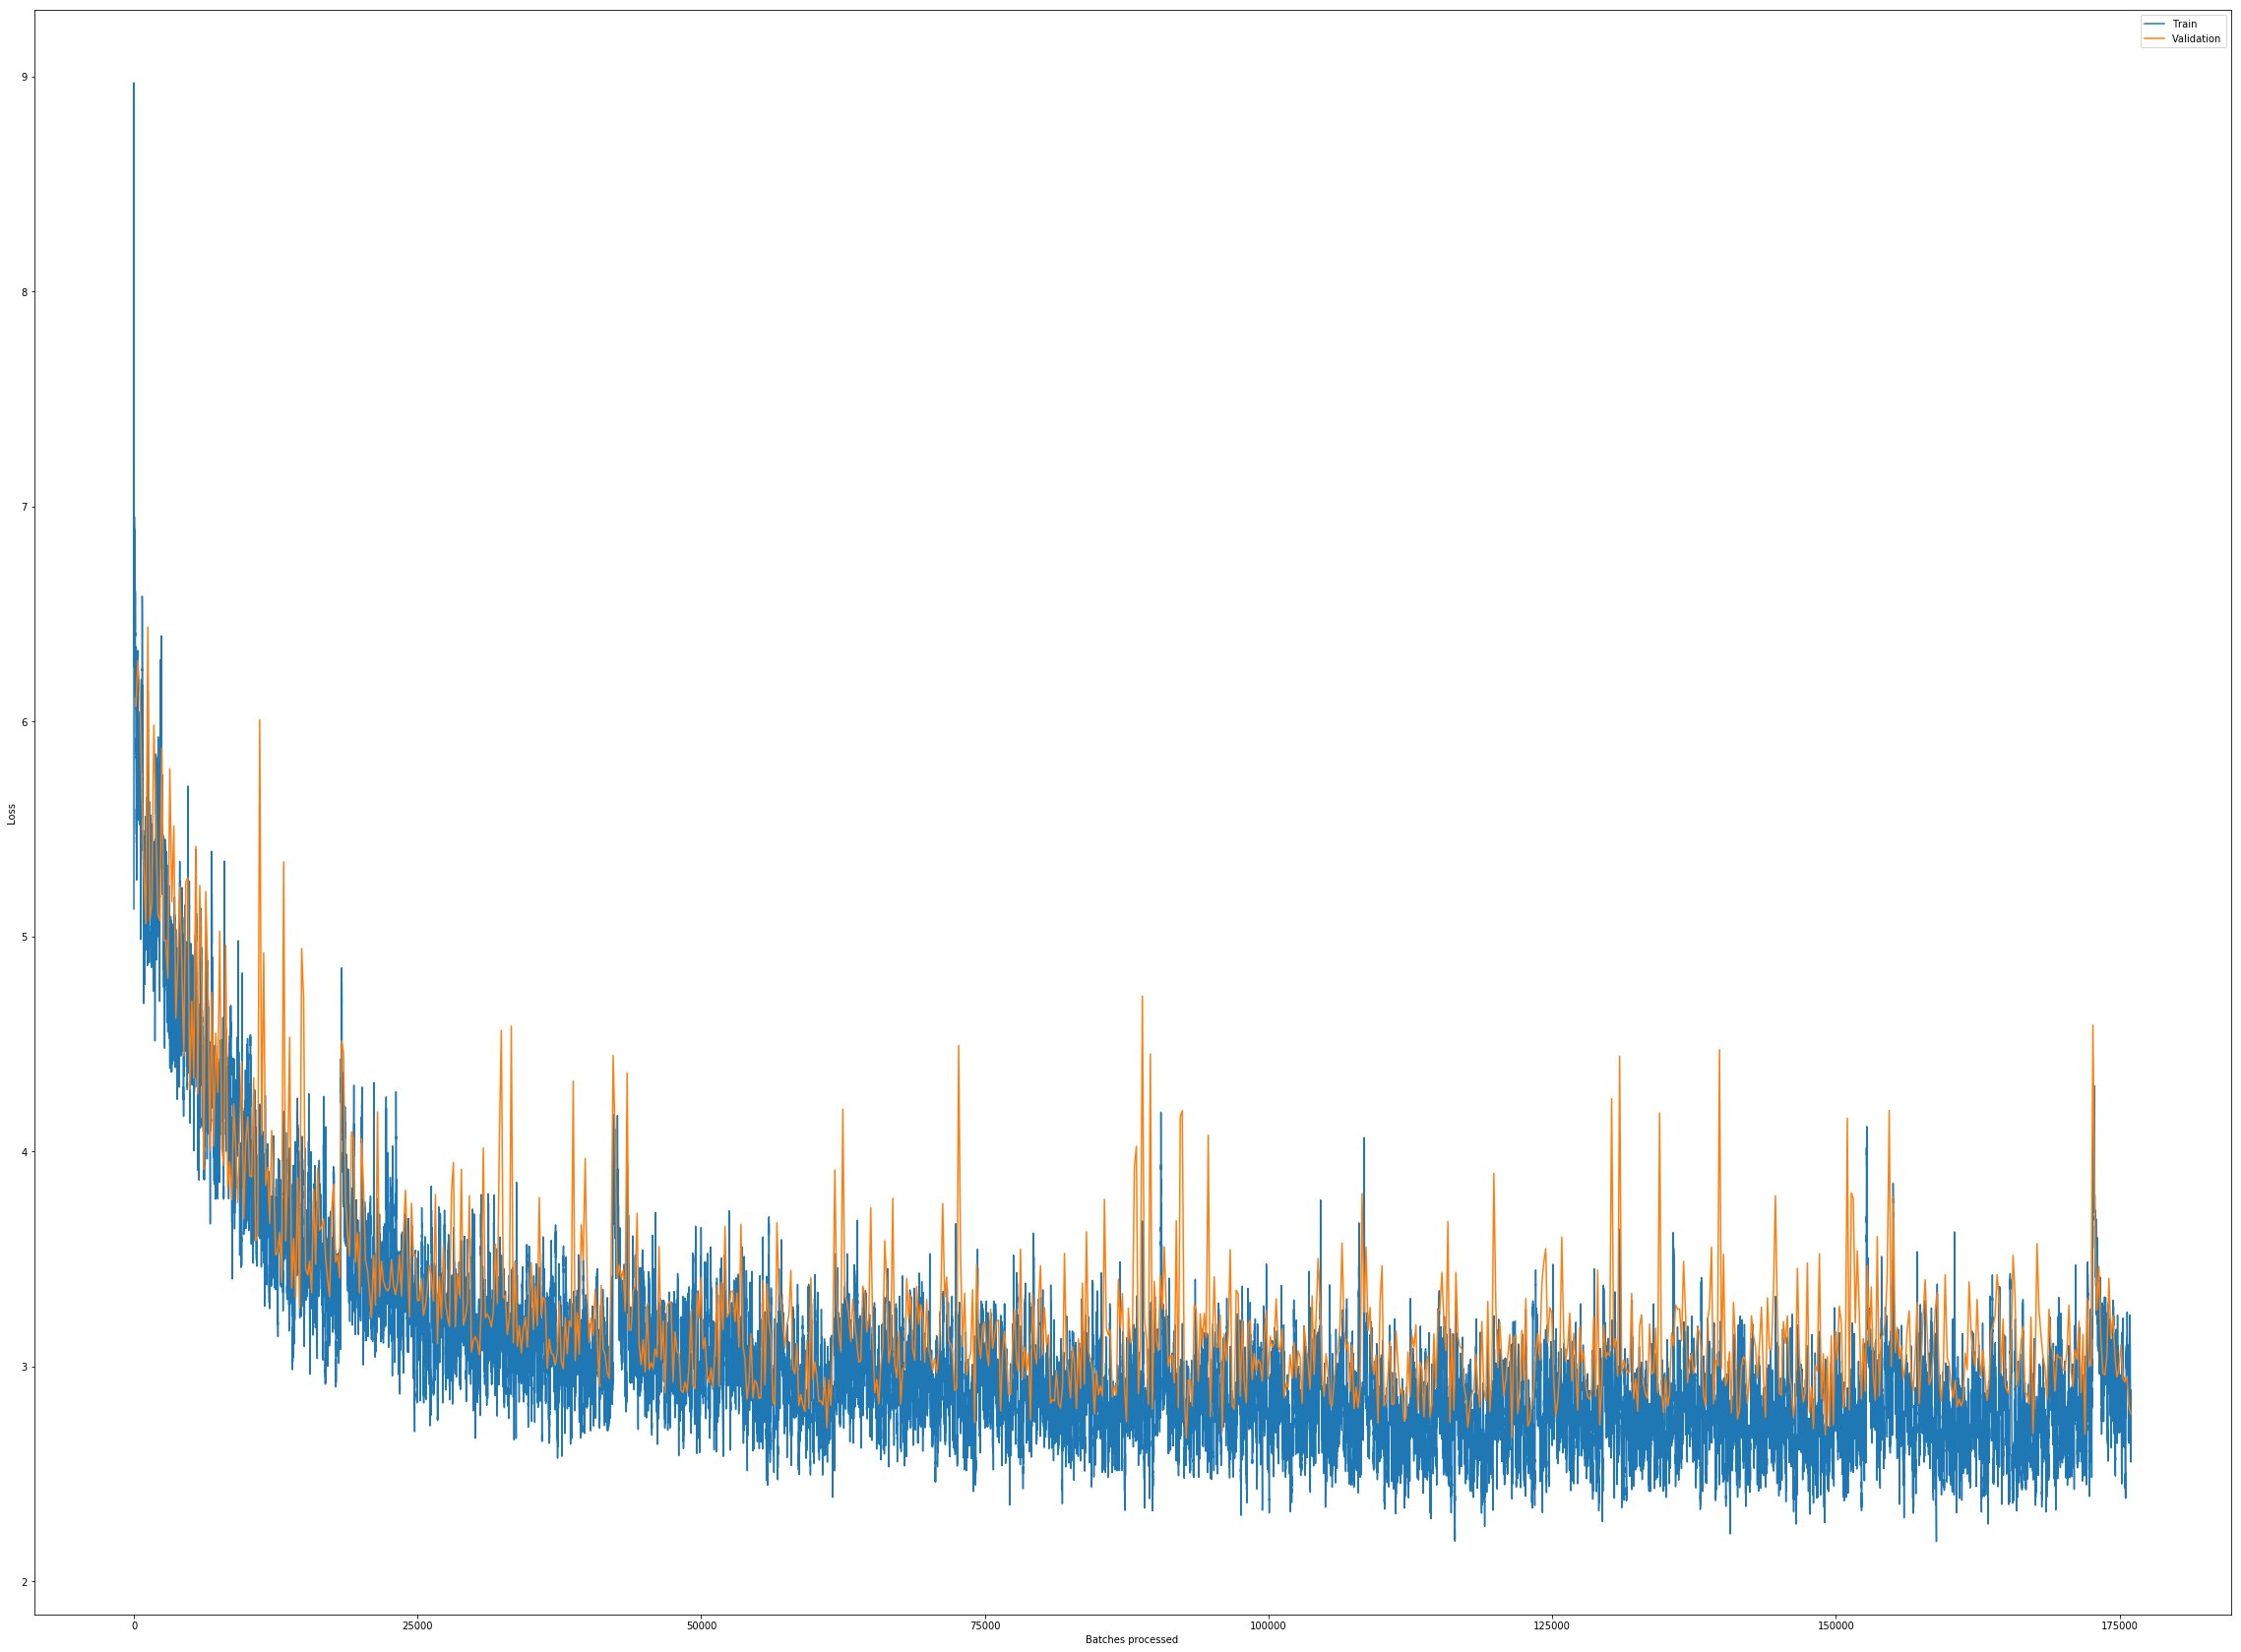

In [131]:
l.recorder.plot_losses()

In [123]:
l2 = fai.Learner(db, m, loss_func=criterion)

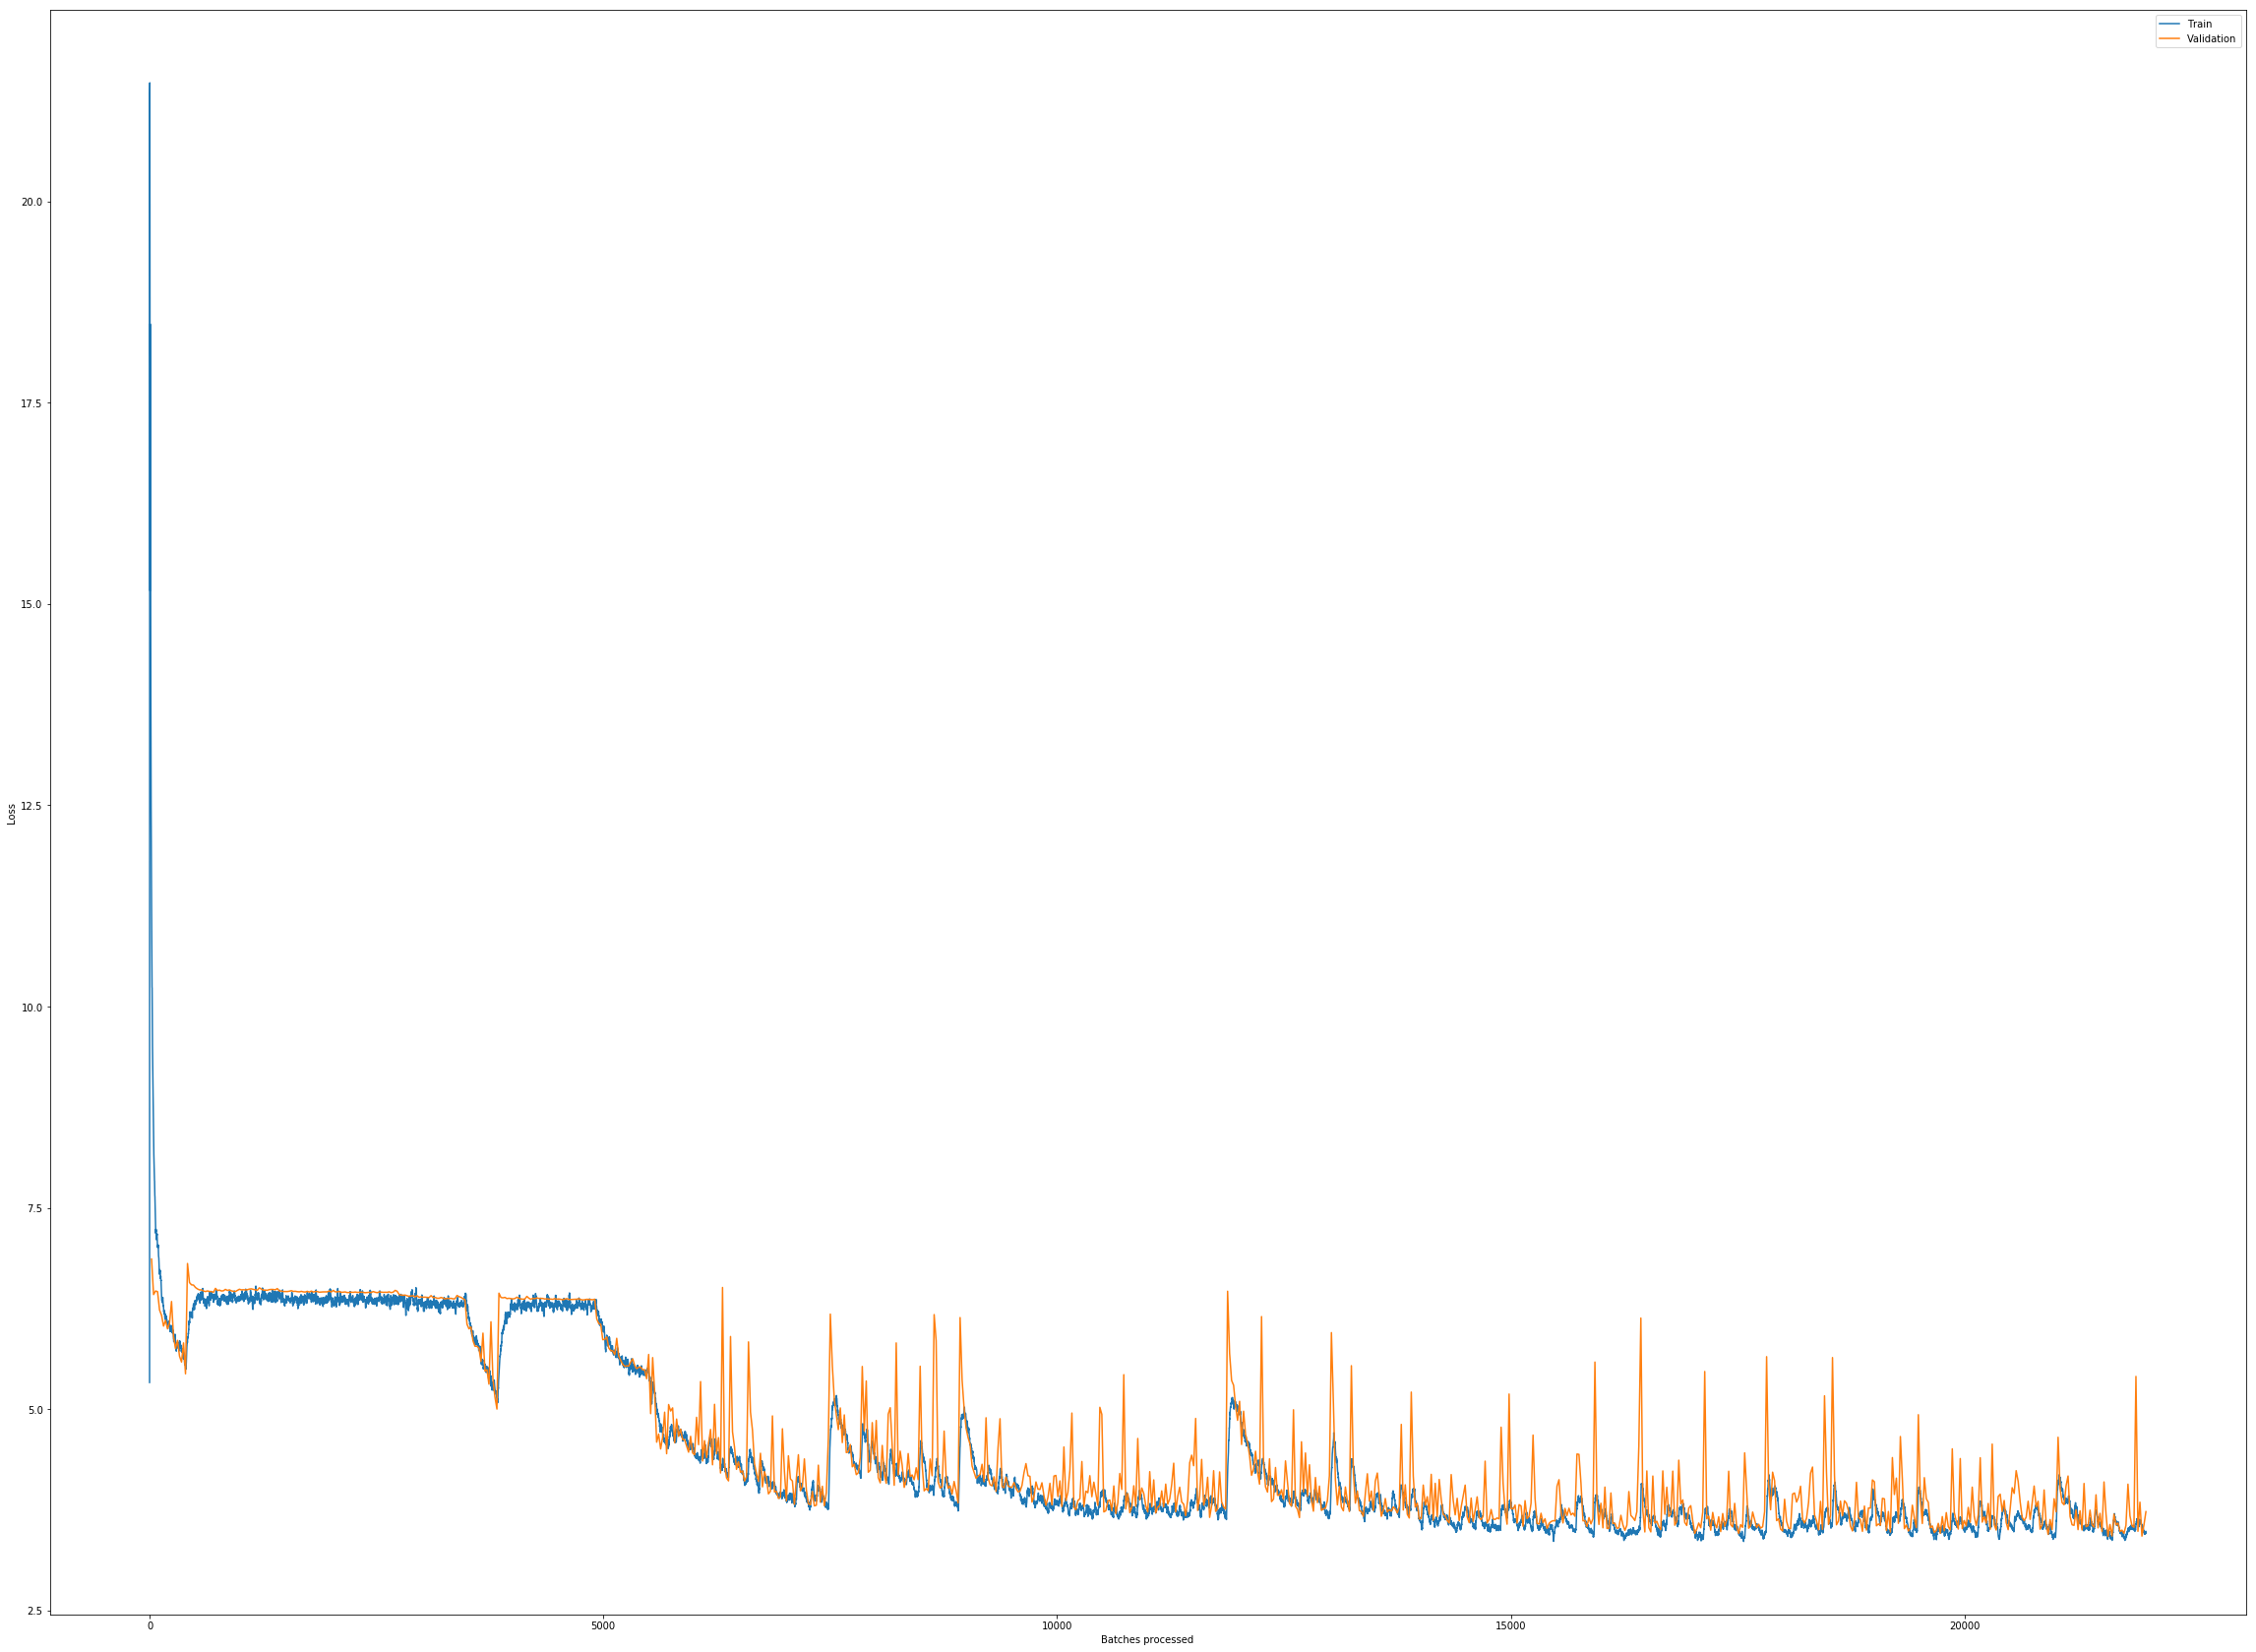

In [129]:
l2.recorder.plot_losses()

In [318]:
p = l.get_preds(fai.basic_data.DatasetType.Train)

In [319]:
preds, targets = p[0].numpy(), p[1].numpy()

In [320]:
preds = np.squeeze(preds); targets = np.squeeze(targets)

In [321]:
diff = np.abs(targets - preds)
se  = np.square(targets - preds)
rse = np.sqrt(se)

bins = [0, 0.25, 0.5, 0.75, 1, 1.5, 2, 3, 67]
hist, _ = np.histogram(diff, bins=bins)

In [315]:
total = sum(hist)

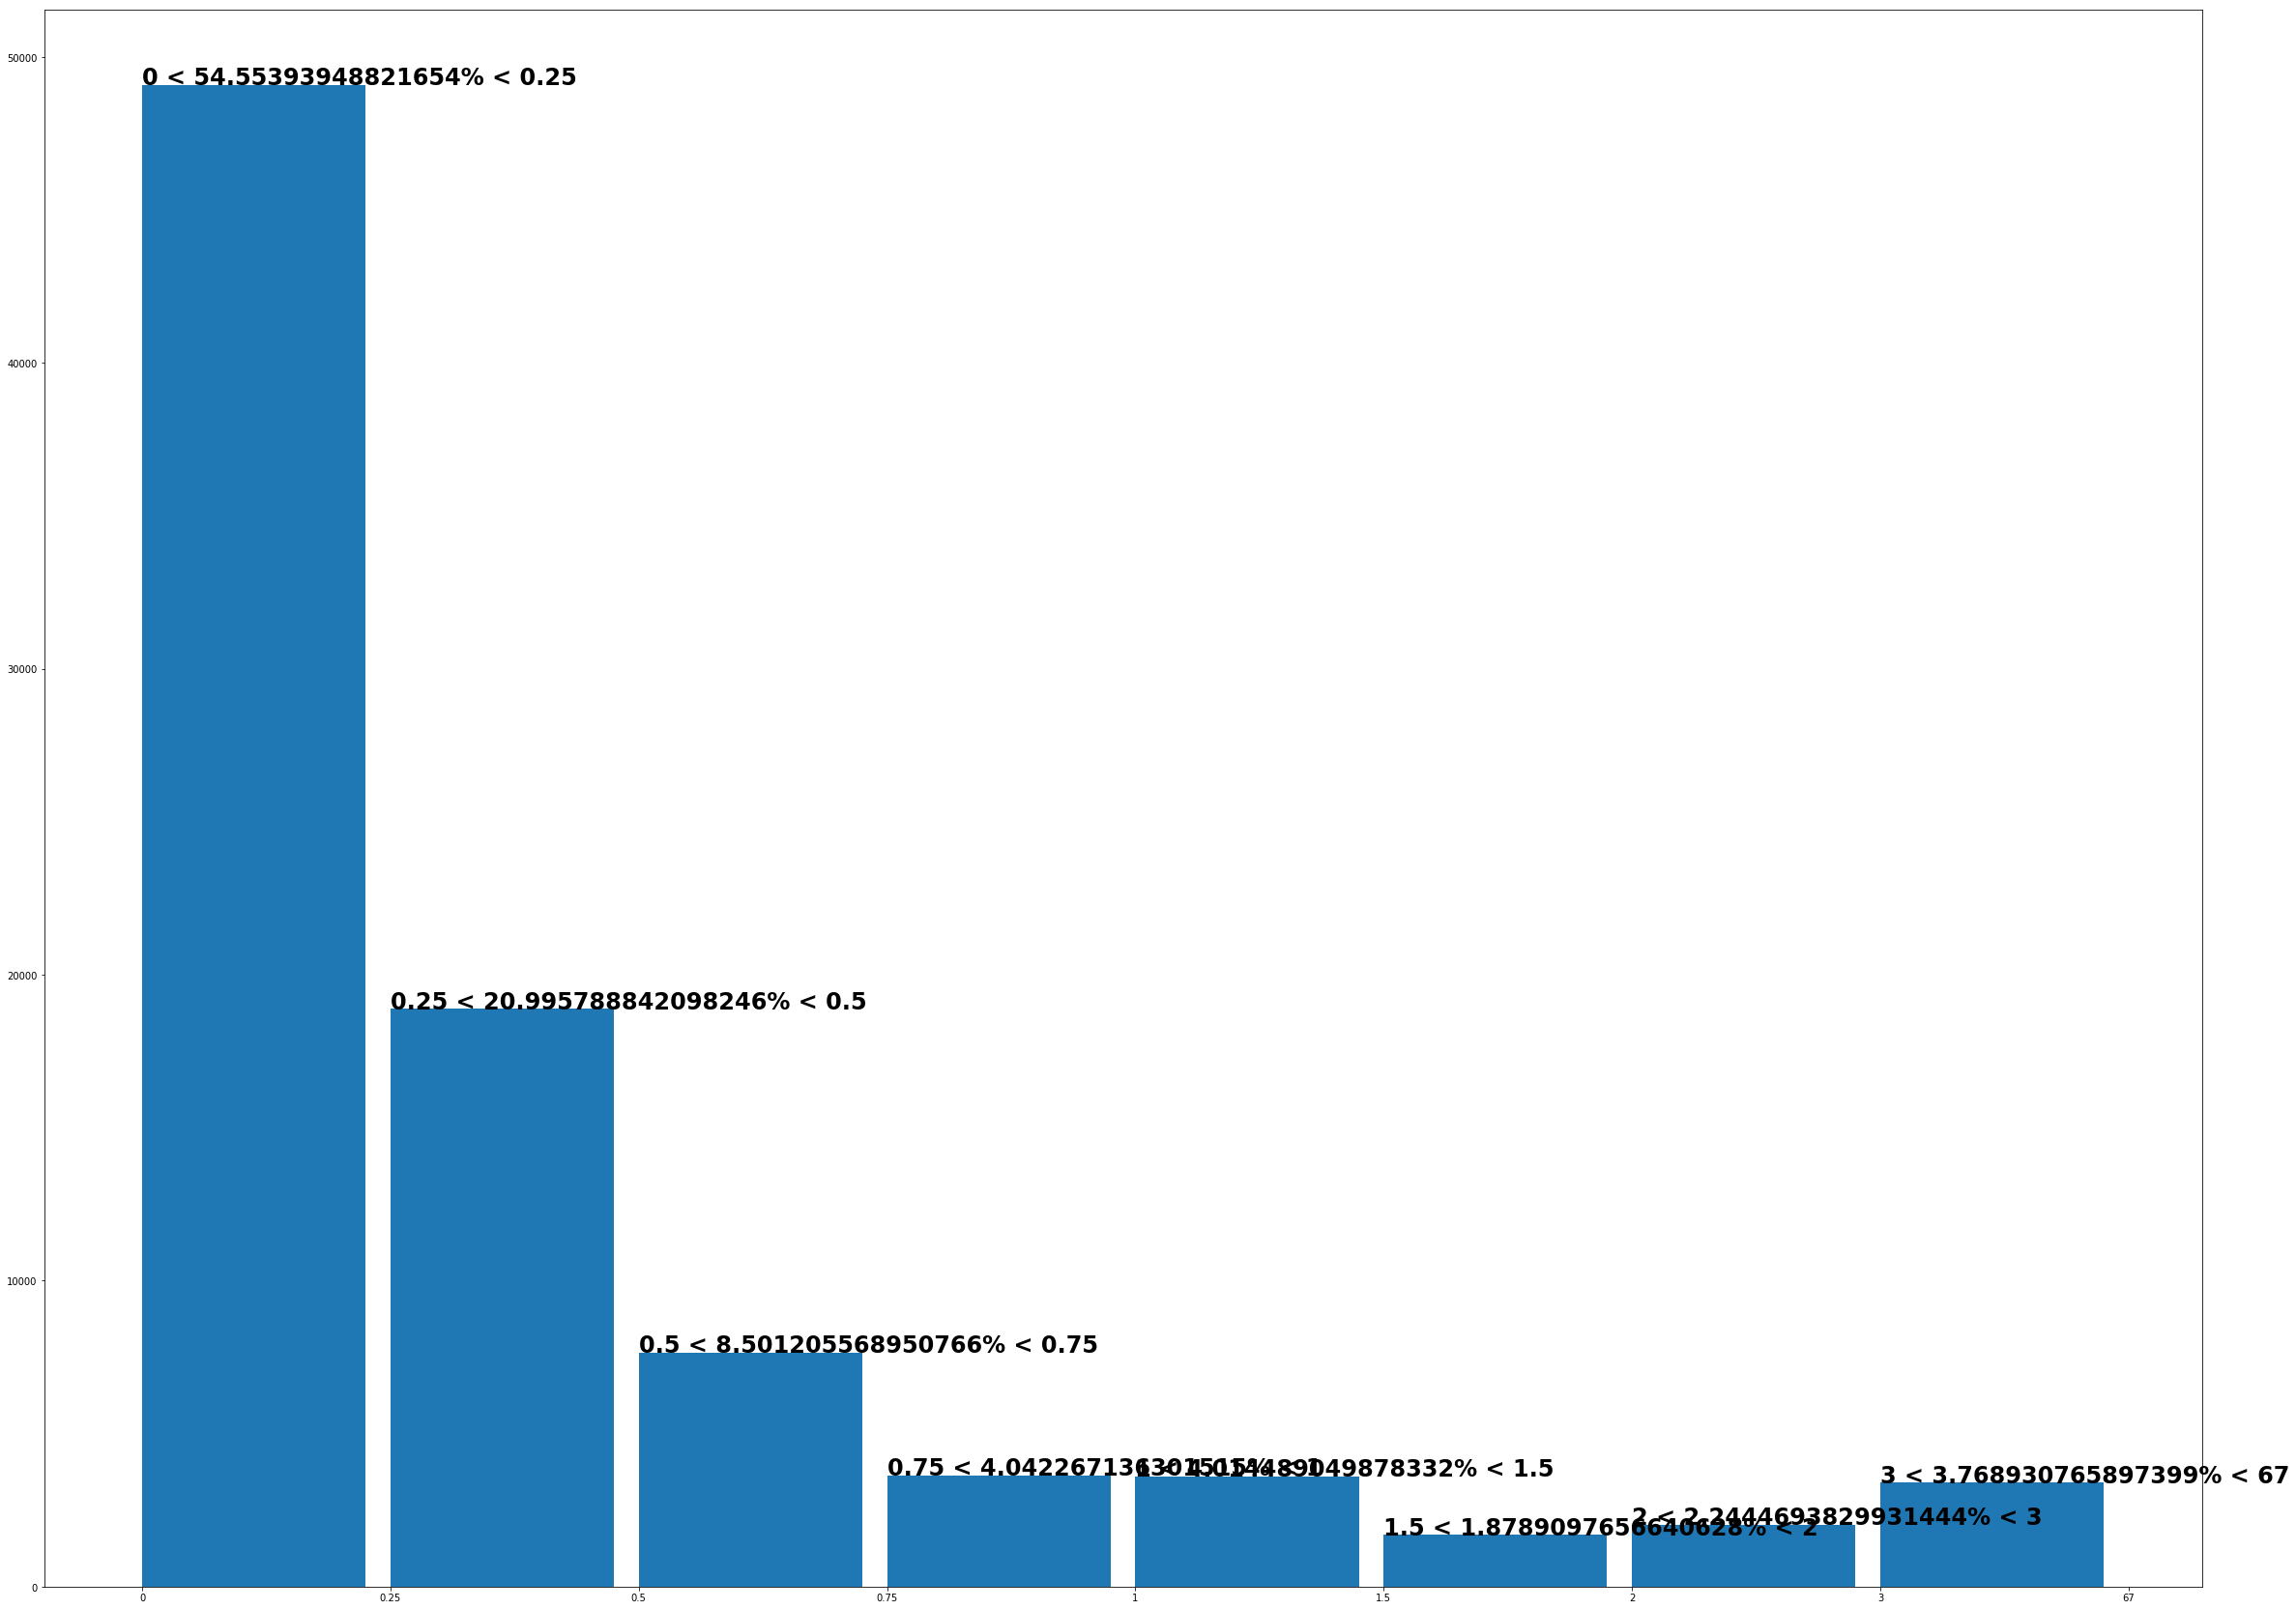

In [316]:
fig, ax = plt.subplots()
ax.bar(range(len(hist)), hist, align='edge', width=0.9)
ax.set_xticklabels([0] + [str(x) for x in bins])

for x, y in enumerate(hist):
    ax.text(x, y+3.7, f"{bins[x]} < {y/total*100}% < {bins[x+1]}", fontweight='bold',fontsize=24)
    




In [323]:
import pandas as pd

df = pd.DataFrame()
df['abs_diff'] = diff
df['square_error'] = se
df['root_square_error'] = rse
df.describe()

,abs_diff,square_error,root_square_error
count,9.000000e+04,9.000000e+04,9.000000e+04
mean,5.894000e-01,2.769686e+00,5.894000e-01
std,1.556433e+00,4.149841e+01,1.556433e+00
min,9.536743e-07,9.094947e-13,9.536743e-07
25%,8.240670e-02,6.790864e-03,8.240670e-02
50%,2.152451e-01,4.633046e-02,2.152451e-01
75%,4.899628e-01,2.400635e-01,4.899628e-01
max,6.892649e+01,4.750861e+03,6.892649e+01


In [356]:
new_l = fai.Learner(db, m, loss_func=criterion).to_fp16()
